# Description
This notebook prepares a plot of the data next to the MLE fit.

In [1]:
import json
import matplotlib
from matplotlib import pyplot, cm
import matplotlib.image as mpimg
from matplotlib.ticker import FormatStrFormatter
from mpl_toolkits.axes_grid1.inset_locator import InsetPosition, mark_inset
import numpy
import pandas
import pathlib

import calibr8
import murefi

import models
import plotting

DP_PROCESSED = pathlib.Path("processed")

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
cm_biomass = models.get_biomass_model()
cm_glucose = models.get_glucose_model()
model = models.MonodModel()
dataset = murefi.load_dataset(DP_PROCESSED / "cultivation_dataset.h5")
theta_mapping = models.get_parameter_mapping(rids=dataset.keys())

### Load process model parameters

In [3]:
with open(DP_PROCESSED / "full_dataset_mle.json") as jfile:
    theta_dict = json.load(jfile)

In [4]:
template = murefi.Dataset.make_template_like(dataset, independent_keys=["S", "X"])
prediction = model.predict_dataset(
    template=template, parameter_mapping=theta_mapping, parameters=theta_dict
)

C:\Users\helleckes\AppData\Local\Continuum\miniconda3\envs\dibecs_6.0.5\lib\site-packages\calibr8\core.py:745: RuntimeWarning: invalid value encountered in power
  x_hat = - (x1**(-x1*x3) * numpy.log( ((1/y)**x0 - 1) * numpy.exp(-x0*x4+x2-x4) ) ) / s
C:\Users\helleckes\AppData\Local\Continuum\miniconda3\envs\dibecs_6.0.5\lib\site-packages\calibr8\core.py:745: RuntimeWarning: invalid value encountered in power
  x_hat = - (x1**(-x1*x3) * numpy.log( ((1/y)**x0 - 1) * numpy.exp(-x0*x4+x2-x4) ) ) / s
C:\Users\helleckes\AppData\Local\Continuum\miniconda3\envs\dibecs_6.0.5\lib\site-packages\calibr8\core.py:745: RuntimeWarning: invalid value encountered in power
  x_hat = - (x1**(-x1*x3) * numpy.log( ((1/y)**x0 - 1) * numpy.exp(-x0*x4+x2-x4) ) ) / s
C:\Users\helleckes\AppData\Local\Continuum\miniconda3\envs\dibecs_6.0.5\lib\site-packages\calibr8\core.py:745: RuntimeWarning: invalid value encountered in power
  x_hat = - (x1**(-x1*x3) * numpy.log( ((1/y)**x0 - 1) * numpy.exp(-x0*x4+x2-x4) ) ) 

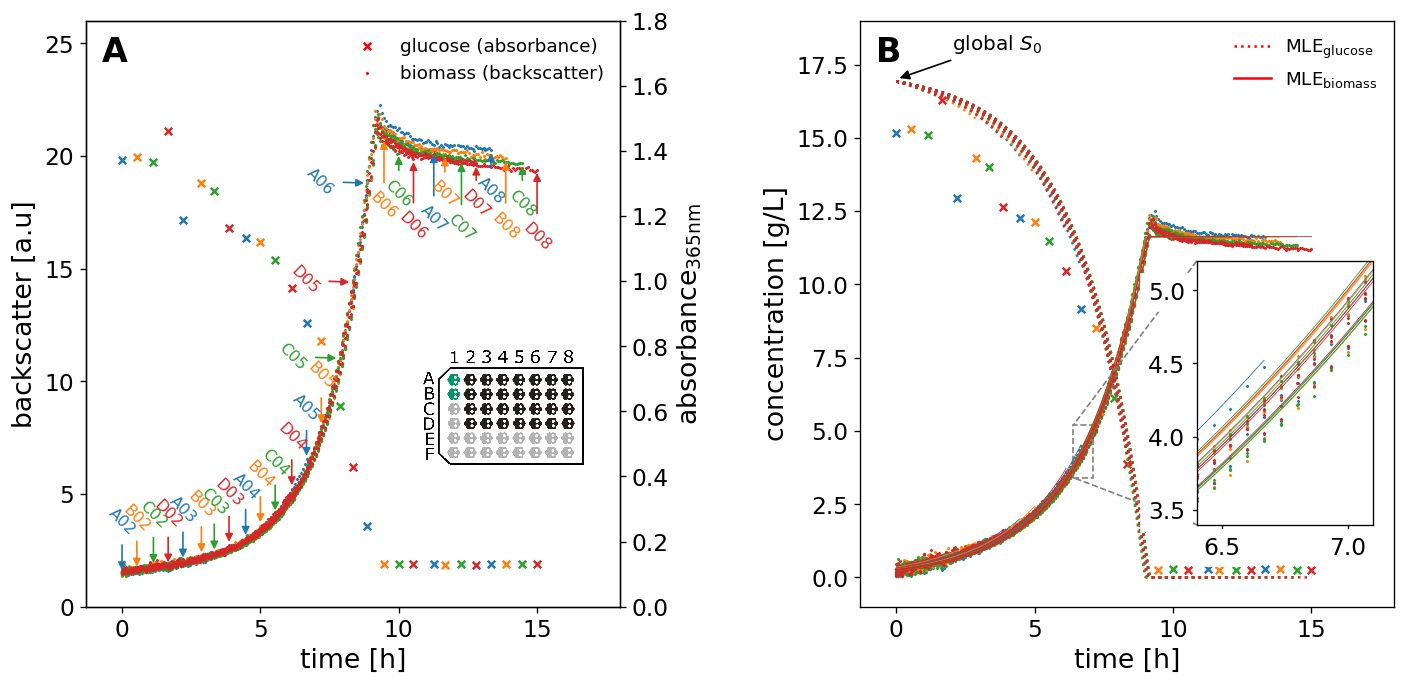

In [5]:
fig, (left, right) = pyplot.subplots(
    dpi=120,
    figsize=(12, 6),
    ncols=2,
    sharex=True
)
left2 = left.twinx()

# ___________________________________Inset plots___________________________________#

# Create a set of inset Axes: these should fill the bounding box allocated to
# them.
ax_inset = pyplot.axes([0, 0, 1, 1])
# Manually set the position and relative size of the inset axes within ax1
ip = InsetPosition(right, [0.63, 0.14, 0.33, 0.45])
ax_inset.set_axes_locator(ip)
# inset plot for left plot (FP)
ax_inset2 = pyplot.axes([1, 1, 0, 0])
# Manually set the position and relative size of the inset axes within ax
ip = InsetPosition(left, [0.63, 0.14, 0.30, 0.4])
ax_inset2.set_axes_locator(ip)
# _________________________________END: Inset plots_________________________________#

# plot the Flowerplate icon
img = mpimg.imread(pathlib.Path("figures") / "4.2.2 FlowerPlate_named.png")
ax_inset2.imshow(img[::-1, ...])
ax_inset2.xaxis.set_visible(False)
ax_inset2.yaxis.set_visible(False)
ax_inset2.spines["bottom"].set_visible(False)
ax_inset2.spines["top"].set_visible(False)
ax_inset2.spines["right"].set_visible(False)
ax_inset2.spines["left"].set_visible(False)

# plot the data
for i, (rid, rep) in enumerate(dataset.items()):
    color = cm.tab10("ABCDEF".index(rid[0]) / 10)

    # X
    ts_t = rep[cm_biomass.dependent_key].t
    ts_y = rep[cm_biomass.dependent_key].y
    left.scatter(
        ts_t,
        ts_y,
        marker="x",
        s=1,
        color=color,
    )
    x, y = ts_t[-1], ts_y[-1]

    ## annotate X
    if x < 7.2:
        x_offset = 0
        y_offset = 1.7

    elif 7.2 < x < 9.2:
        x_offset = -1.7
        y_offset = -0.52

    else:
        x_offset = 0
        if i % 2 == 0:
            y_offset = -2.4
        else:
            y_offset = -3.6
    left.annotate(
        rid,
        xy=(x, y),
        xytext=(x + x_offset, y + y_offset),
        arrowprops=dict(arrowstyle="-|>", facecolor=color, edgecolor=color),
        horizontalalignment="center",
        fontsize=9.5,
        rotation=-45,
        color=color,
    )
    # CDW transformation
    cdw = cm_biomass.predict_independent(ts_y)
    right.scatter(ts_t, cdw, marker="x", s=1, color=color)
    ## inset X
    mask = numpy.logical_and(ts_t > 6.0, ts_t < 7.2)
    ax_inset.scatter(ts_t[mask], cdw[mask], marker="x", s=1, color=color)

    # S
    ts_t = rep[cm_glucose.dependent_key].t
    ts_y = rep[cm_glucose.dependent_key].y
    left2.scatter(
        ts_t,
        ts_y,
        marker="x",
        s=20,
        color=color,
    )
    # concentrations
    glc = cm_glucose.predict_independent(ts_y)
    right.scatter(ts_t, glc, marker="x", s=20, color=color)

    # pred-X
    ts_t = prediction[rid]["X"].t
    ts_y = prediction[rid]["X"].y
    right.plot(ts_t, ts_y, color=color, linestyle="-", lw=0.5)

    ## inset pred X
    mask = numpy.logical_and(ts_t > 6.0, ts_t < 7.2)
    ax_inset.plot(ts_t[mask], ts_y[mask], linestyle="-", lw=0.5, color=color)

    # pred-S
    ts_t = prediction[rid]["S"].t
    ts_y = prediction[rid]["S"].y
    right.plot(ts_t, ts_y, color=color, linestyle=":")
right.annotate(
    "global $S_0$",
    xy=(0, 17),
    xytext=(2, 18),
    arrowprops=dict(arrowstyle="-|>", facecolor="k", edgecolor="k"),
    horizontalalignment="left",
    fontsize=12,
    color="k",
)
# Make correct data labels
right.plot([], [], color="r", linestyle=":", label=r"MLE$_{\mathrm{glucose}}$")
right.plot([], [], color="r", linestyle="-", label=r"MLE$_{\mathrm{biomass}}$")
left.scatter([], [], marker="x", s=20, color="r", label="glucose (absorbance)")
left.scatter([], [], marker="x", s=1, color="r", label="biomass (backscatter)")

# Set axis labels and lims
left.set_ylabel("backscatter [a.u]")
left.set_xlabel("time [h]")
left2.set_ylabel(r"absorbance$_{\mathrm{365nm}}$")
right.set_ylabel("concentration [g/L]")
right.set_xlabel("time [h]")
right.set_xlim(-1.3, 18)
right.set_ylim(-1, 19)
left.set_ylim(0, 26)
left2.set_ylim(0, 1.8)
ax_inset.set_ylim(3.4, 5.2)
ax_inset.set_xlim(6.4, 7.1)

# Make legends
legend1 = left.legend(loc="upper right")
pyplot.setp(legend1.get_texts(), multialignment="center")
right.legend()

# Inset plot box
# Mark the region corresponding to the inset axes on right and draw lines
# in grey linking the two axes.
mark_inset(
    right, ax_inset, loc1=2, loc2=3, fc="none", ec="0.5", zorder=1, linestyle="dashed"
)
pyplot.setp(ax_inset.get_xticklabels(), backgroundcolor="w")
pyplot.setp(ax_inset.get_yticklabels(), backgroundcolor="w")
ax_inset.xaxis.set_major_formatter(FormatStrFormatter("%.1f"))

# Mark subplots with A, B, ...
for i, ax in enumerate((left, right)):
    ax.text(0.03, 0.93, "AB"[i], transform=ax.transAxes, size=20, weight="bold")


pyplot.tight_layout()
pyplot.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.45, hspace=None)
plotting.savefig(fig, "4.2.2 Process Model MLE with data")
pyplot.show()

In [6]:
%load_ext watermark
%watermark

Last updated: 2021-11-24T13:57:54.063347+01:00

Python implementation: CPython
Python version       : 3.8.12
IPython version      : 7.29.0

Compiler    : MSC v.1916 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 158 Stepping 10, GenuineIntel
CPU cores   : 12
Architecture: 64bit

